In [1]:
from pathlib import Path
import os
from os import listdir
from os.path import isfile, join
from scipy.io.wavfile import read
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi, sqrt, exp
import scipy
import librosa
import librosa.display
plt.style.use('seaborn-poster')
%matplotlib inline

In [2]:
root_dir = Path(os.getcwd())
wav_path = root_dir/'wav_database'

In [3]:
sample_word = 'off'

In [4]:
wav_samples = [wav_path/sample_word/f for f in listdir(wav_path/sample_word) if isfile(join(wav_path/sample_word, f))]

In [5]:
wav_samples

[WindowsPath('C:/Users/hydsu/OneDrive/Desktop/Praat/wav_database/off/004ae714_nohash_0.wav'),
 WindowsPath('C:/Users/hydsu/OneDrive/Desktop/Praat/wav_database/off/004ae714_nohash_1.wav'),
 WindowsPath('C:/Users/hydsu/OneDrive/Desktop/Praat/wav_database/off/00b01445_nohash_0.wav'),
 WindowsPath('C:/Users/hydsu/OneDrive/Desktop/Praat/wav_database/off/01b4757a_nohash_0.wav'),
 WindowsPath('C:/Users/hydsu/OneDrive/Desktop/Praat/wav_database/off/01bb6a2a_nohash_0.wav'),
 WindowsPath('C:/Users/hydsu/OneDrive/Desktop/Praat/wav_database/off/01bb6a2a_nohash_1.wav'),
 WindowsPath('C:/Users/hydsu/OneDrive/Desktop/Praat/wav_database/off/01bb6a2a_nohash_2.wav'),
 WindowsPath('C:/Users/hydsu/OneDrive/Desktop/Praat/wav_database/off/01bcfc0c_nohash_0.wav'),
 WindowsPath('C:/Users/hydsu/OneDrive/Desktop/Praat/wav_database/off/01d22d03_nohash_0.wav'),
 WindowsPath('C:/Users/hydsu/OneDrive/Desktop/Praat/wav_database/off/02ade946_nohash_0.wav'),
 WindowsPath('C:/Users/hydsu/OneDrive/Desktop/Praat/wav_data

In [187]:
sample_no = 10
curr_wav = read(wav_samples[sample_no])[1]
print(len(curr_wav))

16000


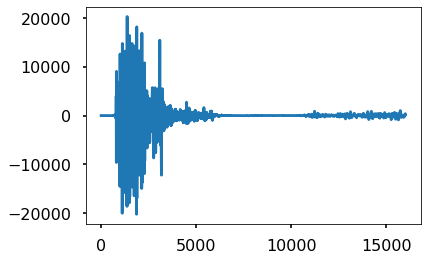

In [188]:
plt.plot(curr_wav)

speechcommands data is sampled at 16 kHz -> 62.5 us. Total length of audio recording is 1s.

Original Praat shape of broadband -> 256 x 991, narrowband -> 512 x 445

Compute short-term spectral analysis: Compute a spectrum of a discrete set of time points in the audio signal.

Spectrogram Parameters:
- Window Length (s): (broadband: 0.005, narrowband: 0.03) Duration of analysis window, affects bandwidth of signal.
    - Given 62.5 us between each sample, to get a 0.005 s window, we take 80 samples. For 0.03 s window -> 480 samples.
- Max Freq (Hz): (broadband & narrowband: 8000 kHz) Highest frequency we want to see. Don't make this more than 2x sample frequency.
- Time Step (s): (broadband & narrowband: 0.01 s) 
    - For a time step of 0.001 s, we move forward by 16 samples per window.
- Frequency Step (Hz): (broadband & narrowband: 20 Hz) 

Formant Acquisition Parameters:
- Time Step (s): (25% of window length)
- Number of Formants: usually 5
- Formant Ceiling (Hz): 6000. Usually 5000-5500 for adults, and can be up to 8000 for children.
- Window Length (s): (0.025) 400 samples
- Preemphasis: (P = 30 Hz). This fits the equation: e^(-2 * pi * P * 6.25e-5), where 6.25e-5 is the sampling period of the sound (1/16000) and P = 30, giving us around 98%, close to a typical value.

# Librosa Version

In [8]:
# n_fft = 2048 # 80 samples
# hop_length = 160 # 160 samples or 16 samples
# stft = librosa.stft(curr_wav/1.0, n_fft=n_fft, hop_length=hop_length)
# abs_stft = np.abs(stft) # converts complex to real
# print(abs_stft.shape)

# fig, ax = plt.subplots(figsize=(9,5))
# librosa.display.specshow(
#     librosa.amplitude_to_db(abs_stft, ref=np.max),
#     y_axis="hz", x_axis="time", ax=ax, fmax=8000)
# plt.ylabel("Frequency (Hz)")
# plt.xlabel("Time (s)")
# plt.ylim([0,8000])

# DFT Demonstration

In [9]:
# # sampling rate
# sr = 100
# # sampling interval
# ts = 1.0/sr
# t = np.arange(0,1,ts)

# freq = 1.
# x = 3*np.sin(2*np.pi*freq*t)

# freq = 4
# x += np.sin(2*np.pi*freq*t)

# freq = 7   
# x += 0.5* np.sin(2*np.pi*freq*t)

# plt.figure(figsize = (8, 6))
# plt.plot(t, x, 'r')
# plt.ylabel('Amplitude')

# plt.show()

In [189]:
def DFT(x):
    """
    x: 1D real-valued signal as a list
    """

    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    e = np.exp(-2j * np.pi * k * n / N)
    
    X = np.dot(e, x)
    
    return X

In [190]:
# X = DFT(x)

# # calculate the frequency
# N = len(X)
# n = np.arange(N)
# T = N/sr
# freq = n/T 

# plt.figure(figsize = (8, 6))
# plt.stem(freq, abs(X), 'b', \
#          markerfmt=" ", basefmt="-b")
# plt.xlabel('Freq (Hz)')
# plt.ylabel('DFT Amplitude |X(freq)|')
# plt.show()

# Make Formants
Courtesy of https://sail.usc.edu/~lgoldste/Ling582/Week%209/LPC%20Analysis.pdf

In [194]:
# Perform pre-emphasis
pre_emph_wav = []
pre_emph_factor = 0.98
for i in range(len(curr_wav)-1):
    pre_emph_wav.append(curr_wav[i+1] - pre_emph_factor*curr_wav[i])
pre_emph_wav = np.array(pre_emph_wav)

In [207]:
from sklearn.linear_model import LinearRegression
from scipy import signal

# From Matlab
signal = pre_emph_wav
sample_rate = 16000
window_size = 400
time_step = 0.25 * window_size
M = 12
num_fft_points = 100 # this will affect how much we pad the LPC coefficients before sending them into FFT

lpc_history = []
for ibeg in range(20, len(signal), int(time_step)):
    iend = ibeg + window_size # iend is the last sample in the window
    Y = signal[ibeg:iend] # Take window_size data points from signal
    if not len(Y) == window_size:
        Y = np.concatenate([Y, [0]*(window_size-len(Y))])

    # X is a (M x window_size) matrix
    X = []
    for i in range(1,M):
        ibeg_delay = (ibeg - i) if (ibeg - i >= 0) else 0
        iend_delay = (iend - i) if (iend - i >= 0) else 0
        signal_delay = signal[ibeg_delay:iend_delay]
        X.append(np.concatenate([[0]*(window_size-len(signal_delay)), signal_delay]))
    X = np.array(X).T


    acoef = LinearRegression().fit(X, Y).coef_
    acoef = np.concatenate([np.array([1]), -acoef])

    acoef_padded = np.concatenate([np.array(acoef), np.array([0]*(num_fft_points-len(acoef)))])
    num = 1
    den = acoef
    transfer = scipy.signal.freqz(num, den)
    lpc = np.log(abs(transfer[1]))
    lpcf = transfer[0]
    lpc_history.append(lpc)
    
# plt.plot(lpcf*sample_rate/(2*np.pi), lpc_history[83])
lpc_diagram = np.vstack(lpc_history)
lpc_diagram = list(map(list, zip(*lpc_diagram)))[::-1]

Text(0, 0.5, 'Hz')

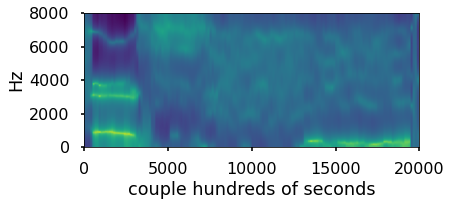

In [208]:
plt.imshow(lpc_diagram, extent=[0, 20000, 0, 8000])
plt.xlabel("couple hundreds of seconds")
plt.ylabel("Hz")

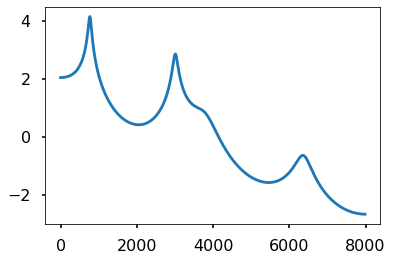

In [209]:
plt.plot(lpcf*sample_rate/(2*np.pi), lpc_history[20])

# Making Formants

In [35]:
# f = open("curr_wav.txt", "w")
# for w in pre_emph_wav:
#     f.write(str(w))
#     f.write('\n')
# f.close()

In [20]:
# # From Numerical Recipes in C
# signal = pre_emph_wav
# sample_rate = 16000
# window_size = 400

# d_history = []
# for ibeg in range(20, 13000, 100):
#     data = signal[ibeg:ibeg+window_size].astype(np.int32) # must convert to 32 bits at least to prevent overflow when computing p

#     n = len(data)
#     m = 12

#     """
#     Given a real vector of data[1...n] and m, this returns m linear prediction coefficients as d[1...m] and
#     the mean square discrepancy xms.
#     """

#     wk1 = [0]*n
#     wk2 = [0]*n
#     wkm = [0]*m
#     d = [0]*m

#     p = 0
#     for j in range(n):
#         p += data[j] * data[j]

#     # xms = ?
#     wk1[0] = data[0]
#     wk2[n-2] = data[n-1]
#     for j in range(1, n-1):
#         wk1[j] = data[j]
#         wk2[j-1] = data[j]

#     for k in range(m):
#         num = 0
#         denom = 0
#         for j in range(n-k):
#             num += wk1[j]*wk2[j]
#             denom += wk1[j]*wk1[j] + wk2[j]*wk2[j]
#         d[k] = 2*num/denom
#         for i in range(k-1):
#             d[i] = wkm[i] - d[k] * wkm[k-i]
#         if k == m:
#             break
#         for i in range(k):
#             wkm[i] = d[i]
#         for j in range(n-k-1):
#             wk1[j] -= wkm[k]*wk2[j]
#             wk2[j] = wk2[j+1]-wkm[k]*wk1[j+1]
    
#     d_history.append(d)

In [198]:
# num_padding = 100

# windowed_coefs = d_history[60] * np.hamming(len(d_history[60]))
# signal = np.concatenate([windowed_coefs, np.array([0]*num_padding)])
# XF = np.log(abs(DFT(signal)))
# plt.plot(XF[0:len(XF)//2], label="60")

# windowed_coefs = d_history[70] * np.hamming(len(d_history[70]))
# signal = np.concatenate([windowed_coefs, np.array([0]*num_padding)])
# XF = np.log(abs(DFT(signal)))
# plt.plot(XF[0:len(XF)//2], label="70")

# windowed_coefs = d_history[80] * np.hamming(len(d_history[80]))
# signal = np.concatenate([windowed_coefs, np.array([0]*num_padding)])
# XF = np.log(abs(DFT(signal)))
# plt.plot(XF[0:len(XF)//2], label="80")

# plt.legend()

In [199]:
# plt.figure(figsize=(15,8))
# for i in range(6):
#     plt.plot(np.array(d_history)[:,i], label=str(i))
# plt.legend()

# Making Spectrograms

In [200]:
window_size = 80 # 80 samples per window. 16 kHz sample rate -> 5 ms window 
time_step = 16 # Move forward 16 samples per window.
num_padding = 400 # Amount to pad by, in number of samples. Total samples = num_padding + window_size
windows = []
spectrums = []

i = 0
while (i*time_step+window_size < len(curr_wav)):
    curr_window = curr_wav[i*time_step:i*time_step+window_size]
    if len(curr_window) != window_size: # pad the last few windows that are clipped at the end
        curr_window = np.concatenate([curr_window, np.array([0]*(window_size-len(curr_window)))])
    windows.append(curr_window)
    i += 1
        
for w in windows:
    window_kernel = np.hamming(window_size) # experiment with other kernels like Gaussian and Hann
    windowed = w * window_kernel
    padded = np.concatenate([windowed, np.array([0]*num_padding)])
    spectrum = abs(DFT(padded))
    spectrum = spectrum[0:len(spectrum)//2]
    spectrum = np.log(spectrum + 0.00001)
    spectrums.append(spectrum)
    
spectrums = np.vstack(spectrums)
spectrums = list(map(list, zip(*spectrums)))[::-1]

Text(0, 0.5, 'Hz')

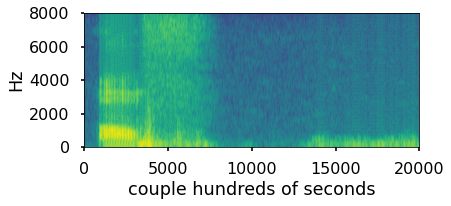

In [201]:
plt.imshow(spectrums, extent=[0, 20000, 0, 8000])
plt.xlabel("couple hundreds of seconds")
plt.ylabel("Hz")

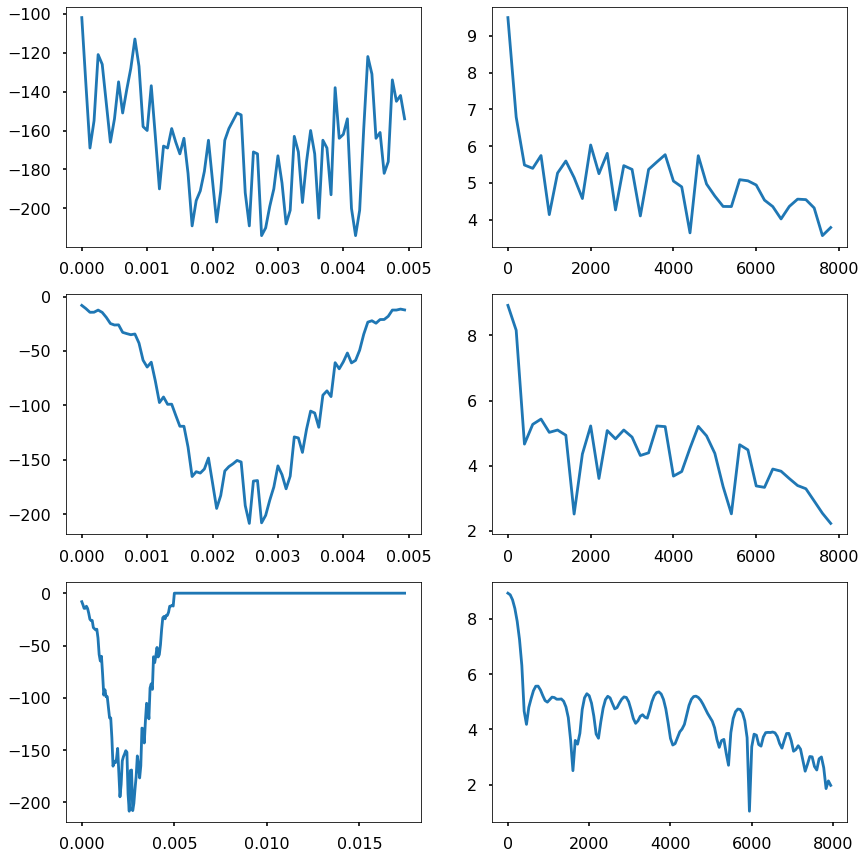

In [153]:
nrows = 3
ncols = 2
figure, ax = plt.subplots(nrows, ncols, figsize=(14,15))

# ----- Time domain of original window ----- #
sr = 16000 # 16 KHz
ts = 1.0/sr
t = np.arange(0,ts*window_size,ts)
x = windows[85]

ax[0,0].plot(t, x)

# ----- Freq. response of original window ----- #
X = DFT(x)
N = len(X)
n = np.arange(N)
T = N/sr
freq = n/T 

ax[0,1].plot(freq[0:len(freq)//2], np.log(abs(X)[0:len(X)//2])) # // 2 to only plot below Nyquist

# ----- Time domain after windowing ----- #
x_windowed = x * np.hamming(80)
ax[1,0].plot(t, x_windowed)

# ----- Freq. response of windowed window ----- #
X_windowed = DFT(x_windowed)
ax[1,1].plot(freq[0:len(freq)//2], np.log(abs(X_windowed)[0:len(X_windowed)//2])) # // 2 to only plot below Nyquist

# ----- Zero-pad signal to increase freq. resolution ----- #
num_padding = 200
x_padded = np.concatenate([x_windowed, np.array([0]*num_padding)])
t_padded = np.arange(0, ts*(window_size+num_padding), ts)
ax[2,0].plot(t_padded, x_padded)

# ----- Freq. response of padded window ----- #
X_padded = DFT(x_padded)
N_padded = len(X_padded)
n_padded = np.arange(N_padded)
T_padded = N_padded/sr
freq_padded = n_padded/T_padded
ax[2,1].plot(freq_padded[0:len(freq_padded)//2], np.log(abs(X_padded)[0:len(X_padded)//2])) # // 2 to only plot below Nyquist